In [ ]:
!pip install transformers sentencepiece rouge -qq

In [ ]:
import torch
import pandas as pd
from rouge import Rouge
from transformers import pipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

1: Load the Train and Test Datasets

In [ ]:
train_data = pd.read_csv("dataset/train.csv")
test_data = pd.read_csv("dataset/test.csv")

In [ ]:
train_data.head()

,Title,Summary,Case
0,Company may continue arbitration despite appro...,The issue whether a company involved in arbitr...,IN THE CIVIL APPELLATE JURISDICTION CIVIL APPE...
1,"Arbitration, Conciliation and Mediation are th...",The objective of Arbitration is to settle the...,AFR Judgment reserved on 01.11.2021 Judgment ...
2,The petitioner was at best consuming narcotics...,It is directed that the petitioner be released...,IN THE HIGH COURT OF DELHI AT NEW DELHI NAMAN ...
3,Cases of Two Petitioners Identical Will Be Bar...,The two orders issued in exaltedly similarly q...,IN THE HIGH COURT OF JUDICATURE AT PATNA Civil...
4,Swachh Bharat Mission’s objective is to ensure...,The guidelines of Swachha Bharat Mission (Urba...,on 18 05 2021 on 22 03 civil ao st 9596 21 & ...


In [ ]:
test_data.head()

,Title,Summary,Case
0,"S.86(1)(f) of the Electricity Act, is a specia...",Section 86(1)(f) vests a statutory jurisdictio...,Reportable IN THE CIVIL APPELLATE JURISDICTION...
1,"The petitioners were released on bail, as the ...",The petitioner apprehended arrest under Sectio...,IN THE HIGH COURT OF JUDICATURE AT PATNA CRIMI...
2,The allegation being only that the petitioner ...,The petitioner was arrested under Sections 344...,IN THE HIGH COURT OF JUDICATURE AT PATNA CRIMI...
3,"In service jurisprudence, seniority cannot be ...",In matters concerning administrative appointme...,IN THE HIGH COURT OF DELHI AT NEW DELHI Judgm...
4,The statute does not mandate all components of...,The facts and information of the suspected off...,on 06 04 2021 on 07 04 1606.19APPLN.odt1IN TH...


In [ ]:
print("Train Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)

Train Data Shape: (2058, 3)
Test Data Shape: (1015, 3)


In [ ]:
trainCasesText = train_data['Case'][:101]
trainGoldSummary = train_data['Summary'][:101]

testCasesText = test_data['Case'][:11]
testGoldSummary = test_data['Summary'][:11]

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_name = "google/pegasus-billsum"

pegasus_tokenizer = PegasusTokenizer.from_pretrained(model_name)
pegasus_model = PegasusForConditionalGeneration.from_pretrained(model_name).to(device)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-billsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2: Generate Summaries for the Train Dataset

In [ ]:
# Generate summaries for the first train data
encoded_data_train = pegasus_tokenizer(trainCasesText[0], truncation=True, padding="longest", return_tensors="pt").to(device)
summary_train = pegasus_model.generate(**encoded_data_train)
summary_final_train = pegasus_tokenizer.batch_decode(summary_train, skip_special_tokens=True)[0]

In [ ]:
# Evaluate the summary using the ROUGE metric
rouge = Rouge()
score_train = rouge.get_scores(summary_final_train, trainGoldSummary[0])
print("ROUGE scores for the first train data:")
print(pd.DataFrame(score_train[0]).iloc[0])

ROUGE scores for the first train data:
rouge-1    0.137931
rouge-2    0.019672
rouge-l    0.114943
Name: r, dtype: float64


3: Generate summaries for the test data

In [ ]:
# Generate summaries for the first test data
encoded_data_test = pegasus_tokenizer(testCasesText[0], truncation=True, padding="longest", return_tensors="pt").to(device)
summary_test = pegasus_model.generate(**encoded_data_test)
summary_final_test = pegasus_tokenizer.batch_decode(summary_test, skip_special_tokens=True)[0]


In [ ]:
# Evaluate the summary using the ROUGE metric
score_test = rouge.get_scores(summary_final_test, testGoldSummary[0])
print("\nROUGE scores for the first test data:")
print(pd.DataFrame(score_test[0]).iloc[0])


ROUGE scores for the first test data:
rouge-1    0.037736
rouge-2    0.006224
rouge-l    0.037736
Name: r, dtype: float64


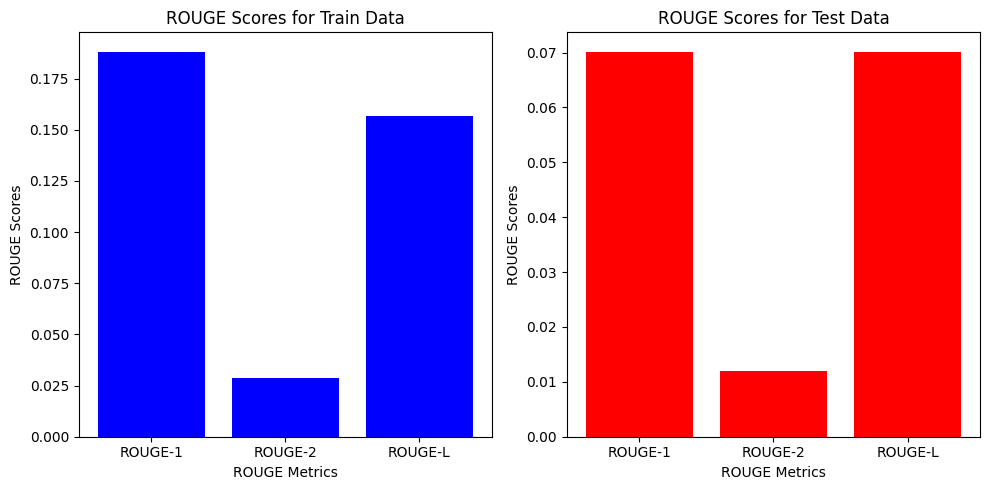

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract ROUGE scores for train data
rouge_1_train = score_train[0]['rouge-1']['f']
rouge_2_train = score_train[0]['rouge-2']['f']
rouge_l_train = score_train[0]['rouge-l']['f']

# Evaluate the summary using the ROUGE metric for test data
score_test = rouge.get_scores(summary_final_test, testGoldSummary[0])

# Extract ROUGE scores for test data
rouge_1_test = score_test[0]['rouge-1']['f']
rouge_2_test = score_test[0]['rouge-2']['f']
rouge_l_test = score_test[0]['rouge-l']['f']

# Plotting ROUGE scores
labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
train_scores = [rouge_1_train, rouge_2_train, rouge_l_train]
test_scores = [rouge_1_test, rouge_2_test, rouge_l_test]

x = range(len(labels))

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(x, train_scores, color='blue')
plt.xlabel('ROUGE Metrics')
plt.ylabel('ROUGE Scores')
plt.title('ROUGE Scores for Train Data')
plt.xticks(x, labels)

plt.subplot(1, 2, 2)
plt.bar(x, test_scores, color='red')
plt.xlabel('ROUGE Metrics')
plt.ylabel('ROUGE Scores')
plt.title('ROUGE Scores for Test Data')
plt.xticks(x, labels)

plt.tight_layout()
plt.show()

In [ ]:
# Generate summaries for the next 100 train data points
SystemSummary_train = []


In [25]:
for i, case in enumerate(trainCasesText[1:101]):  # Start from the second data point and go up to 101

    batch = pegasus_tokenizer(case, truncation=True, padding="longest", return_tensors="pt").to(device)
    summary = pegasus_model.generate(**batch)
    summary_final = pegasus_tokenizer.batch_decode(summary, skip_special_tokens=True)[0]

    SystemSummary_train.append(summary_final)

    print(f"Generated summary for train case {i+1}/100")

Generated summary for train case 1/100
Generated summary for train case 2/100
Generated summary for train case 3/100
Generated summary for train case 4/100
Generated summary for train case 5/100
Generated summary for train case 6/100
Generated summary for train case 7/100
Generated summary for train case 8/100
Generated summary for train case 9/100
Generated summary for train case 10/100
Generated summary for train case 11/100
Generated summary for train case 12/100
Generated summary for train case 13/100
Generated summary for train case 14/100
Generated summary for train case 15/100
Generated summary for train case 16/100
Generated summary for train case 17/100
Generated summary for train case 18/100
Generated summary for train case 19/100
Generated summary for train case 20/100
Generated summary for train case 21/100
Generated summary for train case 22/100
Generated summary for train case 23/100
Generated summary for train case 24/100
Generated summary for train case 25/100
Generated

In [29]:
# Convert trainGoldSummary to a list of strings
trainGoldSummary_list = trainGoldSummary[1:101].tolist()

# Evaluate the generated summaries for the train data using the ROUGE metric
score_train_multiple = rouge.get_scores(SystemSummary_train, trainGoldSummary_list, avg=True)

print("\nAverage ROUGE scores for the train data:")
print(pd.DataFrame(score_train_multiple).iloc[0])



Average ROUGE scores for the train data:
rouge-1    0.103860
rouge-2    0.025325
rouge-l    0.094351
Name: r, dtype: float64


Inference on test set

In [30]:
# Generate summaries for the next 10 test data points
SystemSummary_test = []

for i, case in enumerate(testCasesText[1:11]):  # Start from the second data point and go up to 11

    batch = pegasus_tokenizer(case, truncation=True, padding="longest", return_tensors="pt").to(device)
    summary = pegasus_model.generate(**batch)
    summary_final = pegasus_tokenizer.batch_decode(summary, skip_special_tokens=True)[0]

    SystemSummary_test.append(summary_final)

    print(f"Generated summary for test case {i+1}/10")

Generated summary for test case 1/10
Generated summary for test case 2/10
Generated summary for test case 3/10
Generated summary for test case 4/10
Generated summary for test case 5/10
Generated summary for test case 6/10
Generated summary for test case 7/10
Generated summary for test case 8/10
Generated summary for test case 9/10
Generated summary for test case 10/10


In [32]:
# Convert testGoldSummary to a list of strings
testGoldSummary_list = testGoldSummary[1:11].tolist()

# Evaluate the generated summaries for the test data using the ROUGE metric
score_test_multiple = rouge.get_scores(SystemSummary_test, testGoldSummary_list, avg=True)

print("\nAverage ROUGE scores for the test data:")
print(pd.DataFrame(score_test_multiple).iloc[0])



Average ROUGE scores for the test data:
rouge-1    0.083140
rouge-2    0.012989
rouge-l    0.074167
Name: r, dtype: float64


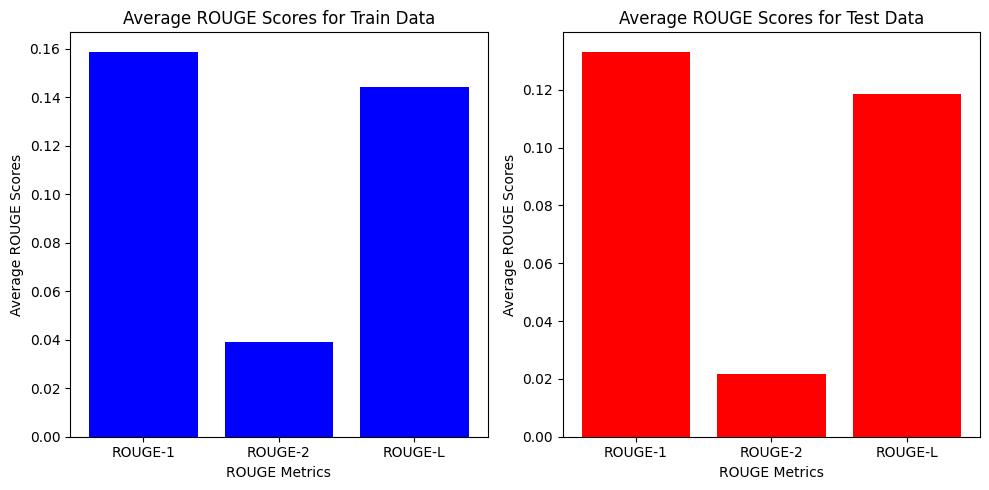

In [42]:
# Extract average ROUGE scores for train data
rouge_1_train_avg = score_train_multiple['rouge-1']['f']
rouge_2_train_avg = score_train_multiple['rouge-2']['f']
rouge_l_train_avg = score_train_multiple['rouge-l']['f']

# Evaluate the generated summaries for the test data using the ROUGE metric
score_test_multiple = rouge.get_scores(SystemSummary_test, testGoldSummary_list, avg=True)

# Extract average ROUGE scores for test data
rouge_1_test_avg = score_test_multiple['rouge-1']['f']
rouge_2_test_avg = score_test_multiple['rouge-2']['f']
rouge_l_test_avg = score_test_multiple['rouge-l']['f']

# Plotting average ROUGE scores
labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
train_avg_scores = [rouge_1_train_avg, rouge_2_train_avg, rouge_l_train_avg]
test_avg_scores = [rouge_1_test_avg, rouge_2_test_avg, rouge_l_test_avg]

x = range(len(labels))

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(x, train_avg_scores, color='blue')
plt.xlabel('ROUGE Metrics')
plt.ylabel('Average ROUGE Scores')
plt.title('Average ROUGE Scores for Train Data')
plt.xticks(x, labels)

plt.subplot(1, 2, 2)
plt.bar(x, test_avg_scores, color='red')
plt.xlabel('ROUGE Metrics')
plt.ylabel('Average ROUGE Scores')
plt.title('Average ROUGE Scores for Test Data')
plt.xticks(x, labels)

plt.tight_layout()
plt.show()

In [33]:
# Save the trained Pegasus model and tokenizer
model_save_path = "./pegasus_model"
pegasus_model.save_pretrained(model_save_path)
pegasus_tokenizer.save_pretrained(model_save_path)


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'min_length': 32, 'num_beams': 8, 'length_penalty': 0.6, 'forced_eos_token_id': 1}


('./pegasus_model\\tokenizer_config.json',
 './pegasus_model\\special_tokens_map.json',
 './pegasus_model\\spiece.model',
 './pegasus_model\\added_tokens.json')

In [43]:
# Save the ROUGE scores to a CSV file
PegasusRouge_train = pd.DataFrame(score_train_multiple).iloc[0]
PegasusRouge_test = pd.DataFrame(score_test_multiple).iloc[0]

In [45]:
PegasusRouge_train.to_csv('PegasusRouge_train.csv')
PegasusRouge_test.to_csv('PegasusRouge_test.csv')

Visualise sample summaries

In [52]:

def visualize_samples(original_texts, generated_summaries):
    for i in range(len(original_texts)):
        print("=" * 50)
        print(f"Sample {i+1}")
        print("Original Text:")
        print(original_texts[i])
        print("\nGenerated Summary:")
        print(generated_summaries[i])
        print("=" * 50 + "\n")

# Sample Summaries for Train Data
print("Sample Summaries for Train Data")
print("=" * 50)
visualize_samples(trainCasesText[:10], SystemSummary_train[:10])

# Sample Summaries for Test Data
print("Sample Summaries for Test Data")
print("=" * 50)
visualize_samples(testCasesText[:10], SystemSummary_test[:10])


Sample Summaries for Train Data
Sample 1
Original Text:
IN THE CIVIL APPELLATE JURISDICTION CIVIL APPEAL NO. 5908 OF 2021 FOURTH DIMENSION SOLUTIONS LTD. Appellant(s VERSUS RICOH INDIA LTD. & ORS. Respondent(s O R D E R Heard learned counsel for the parties. It is indisputable that the Resolution Plan approved by the Committee of Creditors has been finally upheld by this Court vide judgment dated 10.03.2021 in Civil Appeal Nos. 2943 29420 titled as "Kalpraj Dharamshi & Anr. vs. Kotak Investment Advisors Ltd. Anr.” and connected cases reported in 2021 SCC During the hearing of the stated appeal it was brought to the notice of the Court that the appellant had preferred some appeal before the National Company Law Appellate Tribunal and it was still pending at the relevant time. This Court in paragraph 160 of the judgment therefore directed that the said appeal shall proceed on merits. Pursuant to that liberty the concerned appeal has now been decided by the NCLAT vide impugned judgment. I

In [53]:
# Save the generated summaries to CSV files
SystemSummary_train_df = pd.DataFrame({'Original_Text': trainCasesText[1:101], 'Generated_Summary': SystemSummary_train})
SystemSummary_train_df.to_csv('SystemSummary_train.csv', index=False)

SystemSummary_test_df = pd.DataFrame({'Original_Text': testCasesText[1:11], 'Generated_Summary': SystemSummary_test})
SystemSummary_test_df.to_csv('SystemSummary_test.csv', index=False)